In [218]:
import pandas as pd
import numpy as np 
from functools import reduce
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats #libraries for plotting 
from scipy import signal



import warnings
warnings.filterwarnings(action='ignore')

### 2.1 Import data from CSV into pandas dataframe

In [2]:
pdata = pd.read_csv("./Programming_Part1_TTI_Challenge.csv", sep='\t')

In [3]:
stats = pd.DataFrame(pdata.iloc[:,2:].describe())## gather stastics for last two columns
gm = lambda n: reduce(lambda x,y: x*y, n) ** (1.0 / len(n)) ## Function to calculate geometric mean
stats.loc[8] = [gm(pdata.X) , gm(pdata.Y)]

In [4]:
pdata.head()

,Class,PartNo,X,Y
0,AAA,X135,0.21,1.124
1,AAA,X126,0.21,1.179
2,EBHA,X195,0.32,1.191
3,EBHA,X194,0.82,1.249
4,AAA,X139,0.81,1.255


### 2.2 Print all data stastics in one table 

In [5]:
stats.rename(index={8: 'geo.mean'}) ## Last row for geometric mean 

,X,Y
count,100.000000,100.000000
mean,5.499100,3.525130
std,2.672921,1.734591
min,0.210000,1.124000
25%,3.515000,2.086250
50%,5.310000,2.974000
75%,7.810000,4.919500
max,10.020000,7.498000
geo.mean,4.495324,3.108310


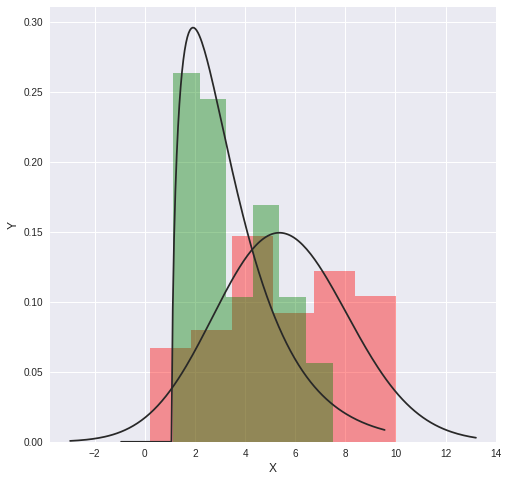

In [210]:

from scipy import stats

%matplotlib inline
plt.figure(figsize=(8,8)) #set size
sns.distplot((pdata.X),color="red", label="X" ,kde=False, fit=stats.gamma) #try to approximate a distribution over data with fit()
sns.distplot((pdata.Y),color="green",label="Y", kde=False, fit=stats.gamma)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

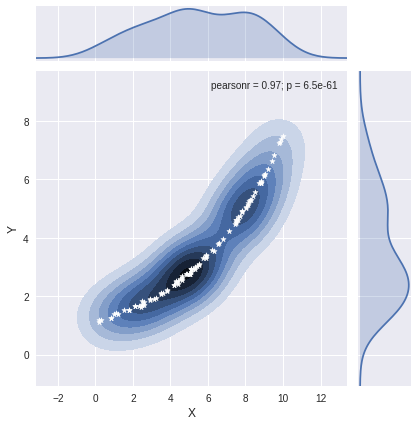

In [7]:
plt.figure(figsize=(14,10)) #set size
g = sns.jointplot(x="X", y="Y", data=pdata, kind="kde"); ## use KDE method to get more idea about the data
g.plot_joint(plt.scatter, c="w", s=30, linewidth=.5, marker="*") ## plot a line in data with all the data points
g.ax_joint.collections[0].set_alpha(0)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

#### From the plots we can see that the two features are highly correlated and form a clear function curve. 

#### 2.3 To write out data to a table, it can be done in many ways but for this exercise I am sqlite db since it is a lightweight and minimal to setup. The connection part can be replace with any database details/jdbc connections, such as Oracle or MySQL.



In [215]:
import sqlite3
conn = sqlite3.connect("new.db")
pdata.to_sql("p1", conn, if_exists="replace")


#### The code also demonstrate that we can convert the data into a RDBMS table and fetch it back.

In [216]:
cur = conn.cursor()
cur.execute("select * from p1 limit 5;")
results = cur.fetchall()
print(results)
conn.commit()
conn.close()

[(0, 'AAA', 'X135', 0.21, 1.124), (1, 'AAA', 'X126', 0.21, 1.179), (2, 'EBHA', 'X195', 0.32, 1.1909999999999998), (3, 'EBHA', 'X194', 0.82, 1.249), (4, 'AAA', 'X139', 0.81, 1.255)]


#### We can convert the Class feature to a categorical one. 

In [9]:
pdata.nunique() #find number of unique categories
pdata.Class.value_counts()

EBHA    41
AAA     38
EBGB    21
Name: Class, dtype: int64

In [10]:
pdata.Class = pdata["Class"].astype("category")

In [11]:
X_cat = pd.get_dummies(pdata , columns=["Class"])
X_cat.drop('Y', 1,inplace=True)

In [12]:
from sklearn.model_selection import train_test_split
X_cat.set_index("PartNo", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_cat, pdata["Y"], test_size=0.33, random_state=2111)

### 2.4  Predictive Model 
### Establish a baseline with a dummy regressor, so we know that we are doing better than predicting mean. 

In [13]:
model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
Y_pred=model.predict(X_test)
print(mean_absolute_error(y_test,Y_pred))

1.63321076436


In [14]:
X_train.head()

,X,Class_AAA,Class_EBGB,Class_EBHA
PartNo,,,,
X170,5.03,0,0,1
X107,4.81,0,1,0
X157,3.50,1,0,0
X162,7.81,0,0,1
X112,9.51,0,1,0


In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

Y_pred=model.predict(X_test)
print("MAE", mean_absolute_error(y_test,Y_pred))
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted'))

MAE 0.412411786194
R2_score 0.924114425336


### From plots we could see that the scatterplot has a very clear function curve, this can be leveraged by using a gradient based learner. 

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=160, learning_rate=0.09,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
print("MAE", mean_absolute_error(y_test, est.predict(X_test)))
print("R2_score",r2_score(y_test,est.predict(X_test), multioutput='variance_weighted'))

MAE 0.0478280763597
R2_score 0.998826076235


/home/raz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/raz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


MAE 0.0510166399985
R2_score 0.998674836216


/home/raz/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


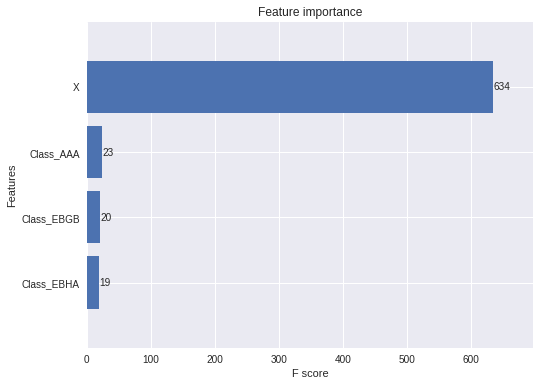

In [217]:
model = XGBRegressor(n_estimators=160,seed=0, learning_rate=0.09)
model.fit(X_train, y_train)
Y_pred=model.predict(X_test)
print("MAE", mean_absolute_error(y_test,Y_pred))
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted'))
from xgboost import plot_importance 
fig, ax = plt.subplots(figsize=(8,6))
plot_importance(model, height=0.8, ax=ax)
plt.show()

#### 2.5 Gradient based methods have resulted in much better performance with near perfect R2 score and low mean absolute error. The reason that simple linear regression did not work so well here could be that the simple linear model could not generalize/model the curve function so well. Where as, since the data curve represented a differentiable function at which gradient models excel. 

#### The low error means that the predictions by this model would only be off by a 0.05 of the actual values. High R2 square suggests that 99.8% of the data can be explained by the model


#### Also, X is the most important feature for predicting the target value. While part number has a little contribution as well.

# 3 SQL Questions 
#### Write the SQL  statements to: 
1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
2. Calculate Total Revenue from Table B 
3. Display the top 10 Products from Table B which made highest profit 
4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 
5. Display the highest selling product and the second highest selling product  
6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order 
7. Find which Quarter sold highest number of products 
8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year 
9. Find the Products in table C that haven’t sold 

In [219]:
s = "../MFG.txt"
conn = sqlite3.connect("new.db")

def get_dtype(s):
    import re    
    if re.match("^\d+?\.\d+?$", s) is None:
        if s.isdigit():
            return "int"
        else:
            return "string"
    return "float"

catFeatures = []
numFeatures = []

def process_dtypes(df):
    for col,x in df.iloc[1,:].iteritems():
        t = get_dtype(str(x).strip())
        if(t == "int" or t == "float" ):
            numFeatures.append(col)
            if t == "int":
                df[col] = df[col].astype(int)
            else:
                df[col] = df[col].astype(float)
        else:
            catFeatures.append(col)
            df[col] = df[col].astype(str)
    return df    

def file_to_table(fn, cols, conn=conn): #helper function to read data from a file and return a dataframe from it.
    table = []
    tname = fn.split(".")[2].strip("/")
    f = open(fn, 'r')
    for i in f:
        table.append(i.strip())
    table = np.reshape(table, [-1,cols])
    columns = table[0,:]
    data = table[1:,:]
    temp = pd.DataFrame(data, columns=columns)
    process_dtypes(temp)
    temp.to_sql(tname, conn, if_exists="replace")
    conn.commit()
    f.close()
    
    return temp

In [220]:
MFG = file_to_table('../MFG.txt',4)
conn = sqlite3.connect("new.db")

products = file_to_table('../product_table.txt',5)
conn = sqlite3.connect("new.db")

sales = file_to_table('../sales_table.txt',7)
conn = sqlite3.connect("new.db")


#### 1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
``` mysql
select RIGHT(a.Full_MFG_Name, LENGTH(a.Full_MFG_Name) -6) as Name , b.* from MFG a, sales_table b where a.MFG_Code = b.MFG_code;

Query #1 (Executed in 4ms)
name 	mfg_code 	product 	quantity 	unit_price 	vaunitprice1 	unit_cost 	dates
KEMET 	KEM 	N 	100 	18.43 	0.03 	13.02 	11/4/2017
KEMET 	KEM 	D 	100 	18.43 	0.03 	13.02 	21/4/2016
KEMET 	KEM 	J 	16 	3.31 	0.0001 	2.45 	26/8/2017
KEMET 	KEM 	K 	1700 	0.545 	0.072 	0.44 	6/9/2017
KEMET 	KEM 	E 	150 	0.8 	0.1666 	0.21 	4/12/2017
Amphenol 	APH 	I 	5 	15.49 	0.35 	13.8618 	15/5/2017
Amphenol 	APH 	H 	5 	16.33 	0.35 	15.2708 	19/8/2017
.
.
.
.
TE Connectivity/Raychem Tubing 	RAY 	K 	5000 	0.03 	0.0016 	0.0172 	5/2/2016

```

#### 2. Calculate Total Revenue from Table B 
#### Total revenue
``` mysql
 select sum(quantity * unit_price) as revenue from sales_table;

revenue
22595.3201681077

```

#### Total Profit  
``` mysql
select sum((quantity * unit_price) - (quantity * unit_cost)) as profit from sales_table order by profit desc LIMIT 10;
    profit
    4281.87903094292
```

#### 3. Display the top 10 Products from Table B which made highest profit

``` mysql

select product, sum((quantity * unit_price) - (quantity * unit_cost)) as profit from sales_table 
group by product 
order by profit desc LIMIT 10;


product 	profit
L 	1068.800573349
N 	540.999984741211
D 	540.999984741211
C 	470.559993743896
K 	402.499992772937
I 	339.161009788513
O 	250
E 	248.499969393015
H 	165.295968055725
F 	91.1389923095703

```


#### 4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 



``` mysql
select a.Parent_MFG , sum(b.Unit_Cost) as Unit_Cost, sum(b.Unit_Price) as Unit_price, (sum( (b.quantity * b.unit_price) - (b.quantity * b.unit_cost) )/sum(b.quantity * b.unit_price) )*100 as profit_margin_pct
from MFG a, sales_table b 
where a.MFG_Code = b.MFG_code
group by a.Parent_MFG
order by a.Parent_MFG;


    Query #4 (Executed in 3ms)
    parent_mfg |	unit_cost |	unit_price |	profit_margin_pct|
    ACG | Amphenol Connector Group 	970.132 	1031.99 	9.20290857973324
    AVC | AVX Corporation 	59.7 	75.85 	14.0426265605136
    KCC | KOA Corporation 	0.75 	0.87 	13.793100967702
    KCO | Kemet Corporation 	29.14 	41.515 	28.4770947263481
    TEG | TE Connectivity Group 	112.814 	224.77 	48.3635106304724
```

#### 5.  Display the highest selling product and the second highest selling product 

```mysql

 select product,sum(quantity*unit_Cost) as sale from sales_table 
 group by product
 order by sale desc limit 2;
 
product 	sale
L 	7915.79961776733
K 	1833.99999886751


```

#### 6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order 

```mysql 
 select 
 abc.type as Type, 
 sum(abc.total_revenue) as total_revenue,
 sum(abc.total_cost) as total_cost 
 from
 (
     select 
     distinct pt.product as product,
    pt.type as type,
     (st.quantity * st.unit_price)       as total_revenue,
     (st.quantity * st.unit_cost) as total_cost
     from product_table pt
    inner join sales_table st
    on(st.product = pt.product)
  ) as abc
  group by abc.type
  order by abc.type desc;

type 	total_revenue 	total_cost
EREL 	16534.8101039827 	14065.0290335119
COMM 	4141.51003456116 	2879.95005607605
```

#### 7  Find which Quarter sold highest number of products

```mysql

select  EXTRACT(YEAR from to_date(dates,'DD/MM/YYYY')) as YEAR, EXTRACT(QUARTER from to_date(dates,'DD/MM/YYYY')) as quart, sum(quantity) as Number_of_products 
from sales_table
group by year,quart
order by Number_of_products desc LIMIT 1;

year 	quart 	number_of_products
2017 	1 	5015

```

#### 8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year 
```mysql
select stt.years, stt.Quarter_num, pt.category, sum(st.quantity * st.Unit_cost) as sale
from sales_table st , product_table pt, 
(select EXTRACT(YEAR from to_date(dates,'DD/MM/YYYY')) as years, EXTRACT(QUARTER from  to_date(dates,'DD MM YYYY')) as Quarter_num from sales_table) as stt
where st.product = pt.product 
and pt.category ='AUTOMOTIVE'
and stt.years = EXTRACT(year from CURRENT_DATE) -1 
group by stt.years, stt.Quarter_num ,pt.category
order by sale desc limit 1 ;
 
years 	quarter_num 	category 	sale
2017 	3 	AUTOMOTIVE 	10210.0002765656

```



#### 9. Find the Products in table C that haven’t sold anything ever 
```mysql
select * from product_table where product not in (select  product from sales_table);

product 	class 	commodity 	category 	type
P 	564 	C/P 	AUTOMOTIVE 	COMM
```

## Part 4

### 4.1 In Python (or Pandas) write a code to import the transaction table 

In [224]:
import pandas as pd
p3 = pd.read_excel(open("./ModelingDataSet.xlsx",'rb'))
# or using sheet index starting 0
p3.set_index("Transaction_ID", inplace=True)
p3.columns = [i.strip().lower() for i in p3.columns]

In [225]:
p3.head()

,unit_cost,quantity,extended_cost,revenue,margin%
Transaction_ID,,,,,
1,0.261167,1200,313.40,468.00,0.330341
2,1.073075,400,429.23,572.00,0.249597
3,0.109778,2880,316.16,662.88,0.523050
4,0.007200,24000,172.80,288.00,0.400000
5,0.012630,10000,126.30,320.00,0.605312


### A quick exploratory analysis of data.

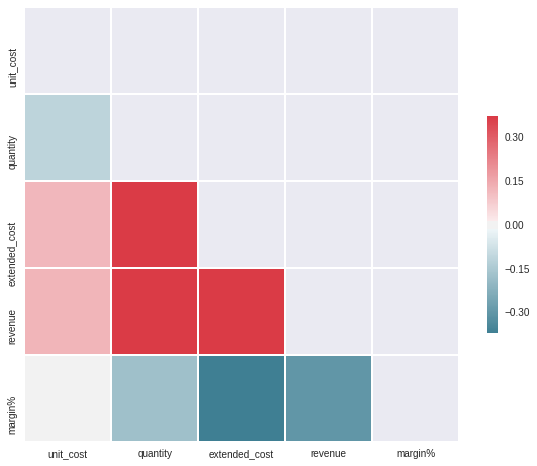

In [238]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,8)})
corr = p3.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [277]:
corr[abs(corr) > .3]

,unit_cost,quantity,extended_cost,revenue,margin%
unit_cost,1.0,NaN,NaN,NaN,NaN
quantity,NaN,1.000000,0.370578,0.391493,NaN
extended_cost,NaN,0.370578,1.000000,0.975273,-0.371363
revenue,NaN,0.391493,0.975273,1.000000,NaN
margin%,NaN,NaN,-0.371363,NaN,1.000000


#### From the correlation plot we can see that the extended_cost has very high correlation to revenue, which makes sense, higher extended cost will result in higher revenue. It also has some correlation to margin, when extended costs go up, marging goes down.


#### A Quick look at distributions of all the features

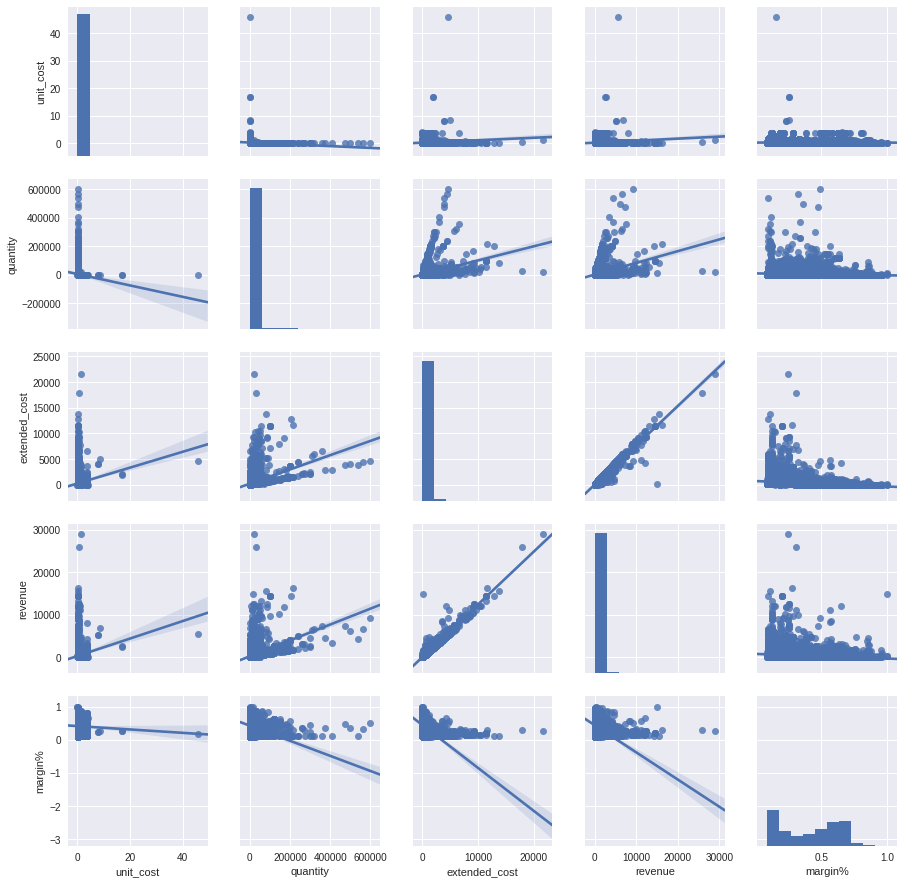

In [292]:
g = sns.pairplot(p3, kind="reg")
sns.set(rc={'figure.figsize':(8,8)})


#### From the plots we can see that the features do not follow any partucular distributions. Also many features contain extreme outlier values that coud impact our analysis. 

#### Some ireatment might be required to make this data more modelable.

#### Performing log transformation could be an option

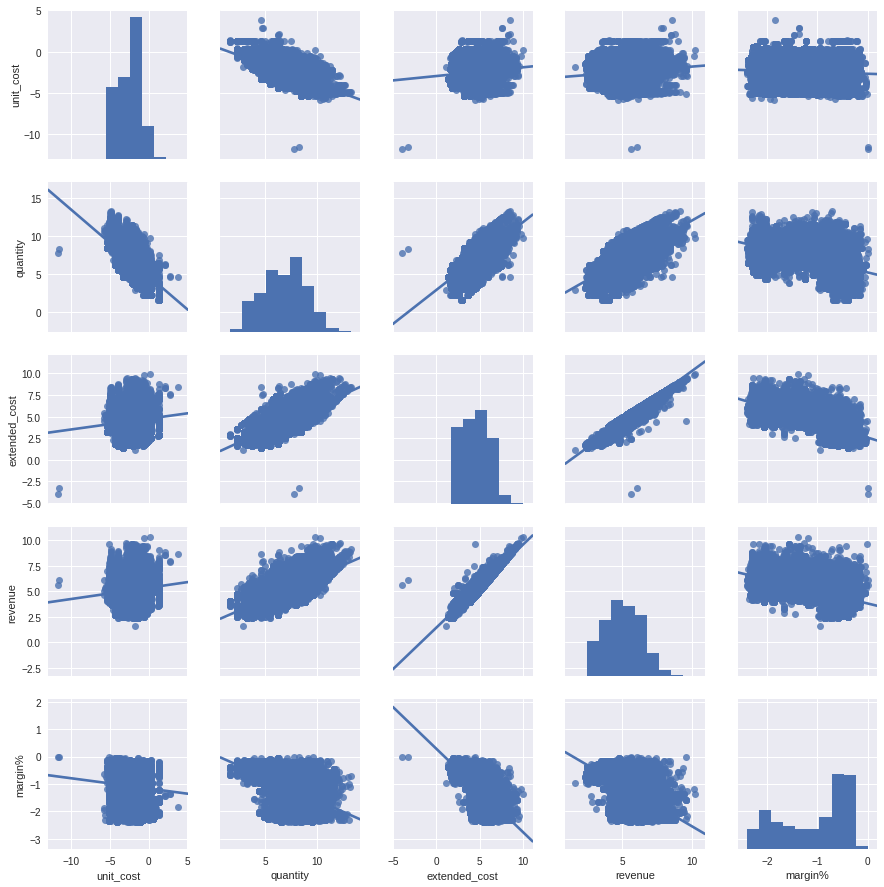

In [298]:
g = sns.pairplot(np.log(p3), kind="reg")
sns.set(rc={'figure.figsize':(8,8)})

In [299]:
import itertools
outliers_lst  = []
log_data =np.log(p3)
# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    Q1 = np.percentile(log_data.loc[:, feature], 15)
    Q3 = np.percentile(log_data.loc[:, feature], 85)
    #Using the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    print("Outliers for the feature '{}':".format(feature), list(outliers_rows[feature]))
    outliers_lst.append(list(outliers_rows.index))
outliers = list(itertools.chain.from_iterable(outliers_lst))
uniq_outliers = list(set(outliers))
# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))
print( 'Total Number of outliers:\n', len(uniq_outliers))
# Remove duplicate outliers
# Only 5 specified
good_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)
# Original Data 
print( 'Original shape of data:\n', p3.shape)
# Processed Data
print( 'New shape of data:\n', good_data.shape)

Outliers for the feature 'unit_cost': [-11.736069016284437, -11.512925464970229, 3.8253603987799]
Outliers for the feature 'quantity': []
Outliers for the feature 'extended_cost': [-3.912023005428146, -3.2188758248682006]
Outliers for the feature 'revenue': []
Outliers for the feature 'margin%': []
Total Number of outliers:
 3
Original shape of data:
 (28103, 5)
New shape of data:
 (28101, 5)


In [ ]:
import numpy as np
temp = pd.DataFrame()
for i in p3.columns:
    temp[i] = np.log(p3[i])
    #temp[i]= (p3[i] - p3[i].min())/(p3[i].max() - p3[i].min() )
    temp[i]= (temp[i] - temp[i].min())/(temp[i].max() - temp[i].min() )
temp

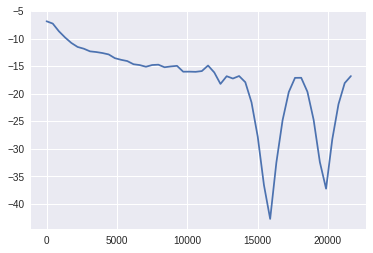

In [31]:
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = p3.extended_cost.values.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=np.mean(p3.extended_cost)).fit(a)
s = linspace(min(p3.extended_cost),max(p3.extended_cost))
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [32]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print( "Maxima:", s[ma])

Minima: [  7064.21591837   8388.75265306   9713.28938776  10596.31387755
  12362.36285714  13245.38734694  15894.46081633  19868.07102041]
Maxima: [  7947.24040816   9271.77714286  10154.80163265  11479.33836735
  12803.87510204  13686.89959184  18102.02204082]


In [43]:
splits = a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]]

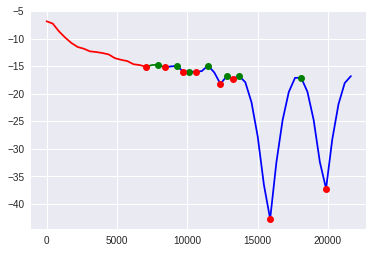

In [44]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

### The Jenks optimization method
Also called the Jenks natural breaks classification method, is a data clustering method designed to determine the best arrangement of values into different classes. This is done by seeking to minimize each class’s average deviation from the class mean, while maximizing each class’s deviation from the means of the other groups.


Calculate the sum of squared deviations between classes (SDBC).

Calculate the sum of squared deviations from the array mean (SDAM).

Subtract the SDBC from the SDAM (SDAM-SDBC). This equals the sum of the squared deviations from the class means (SDCM).

After inspecting each of the SDBC, a decision is made to move one unit from the class with the largest SDBC toward the class with the lowest SDBC.

Finally, the goodness of variance fit (GVF) is calculated. GVF is defined as (SDAM - SDCM) / SDAM. GVF ranges from 0 (worst fit) to 1 (perfect fit).
   

In [258]:
from jenks import jenks
import numpy as np
def goodness_of_variance_fit(array, classes):
    classes = jenks(array, classes)
    classified = np.array([classify(i, classes) for i in array])
    #print(classified)
    array = p3["margin%"].values
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # Calculate the sum of squared deviations from the array mean (SDAM).
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # Calculate the sum of squared deviations between classes (SDBC).
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf, classes

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

In [265]:
#temp = np.exp(good_data)
#jenks(temp.iloc[:,2], 2)
gvf = 0
gvfs = []
nclasses = 2

for nclasses in range(3,15):
    gvf, cls = goodness_of_variance_fit(p3["extended_cost"].values, nclasses)
    print(gvf,nclasses,cls)
    gvfs.append(gvf)
    nclasses += 1

0.105644100155 3 [0.02, 652.25, 3081.6001, 21634.119]
0.155042992142 4 [0.02, 505.34, 2090.6499, 6031.4302, 21634.119]
0.290998622031 5 [0.02, 304.29001, 1003.8, 2636.0, 6350.4502, 21634.119]
0.304107798754 6 [0.02, 277.89999, 800.92999, 1686.58, 3250.53, 6880.2002, 21634.119]
0.30410559062 7 [0.02, 277.89999, 800.92999, 1664.84, 3159.04, 5821.7598, 9644.0, 21634.119]
0.421430472407 8 [0.02, 188.27, 507.84, 1006.08, 1898.55, 3326.72, 5821.7598, 9644.0, 21634.119]
0.475814292113 9 [0.02, 144.24001, 400.39999, 824.0, 1436.0699, 2331.0, 3742.5601, 6031.4302, 9644.0, 21634.119]
0.484858355626 10 [0.02, 132.52, 350.56, 649.38, 1091.0, 1871.55, 3059.3999, 4573.5, 6880.2002, 10185.92, 21634.119]
0.482758751737 11 [0.02, 118.26, 304.29001, 548.79999, 913.04999, 1426.24, 2162.6499, 3211.25, 4676.5801, 6880.2002, 10185.92, 21634.119]
0.482776544463 12 [0.02, 118.26, 304.29001, 548.79999, 913.04999, 1426.24, 2162.6499, 3211.25, 4616.3198, 6703.2402, 9644.0, 13715.7, 21634.119]
0.484608976838 13 [

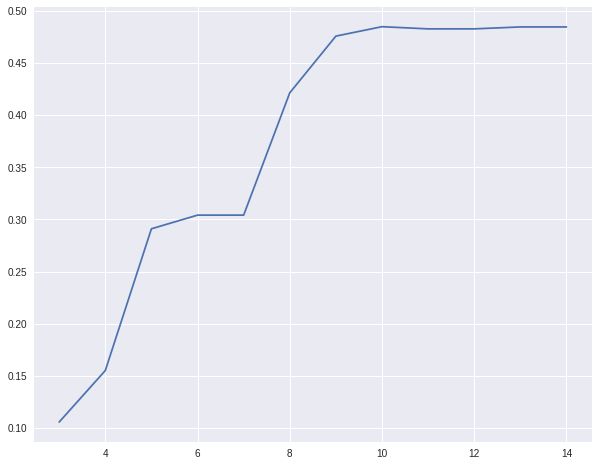

In [269]:
plt.plot(range(3,15), gvfs )
plt.xlabel="number_of_bins"
plt.xlabel="ratio_of_variance_to_mean_difference"

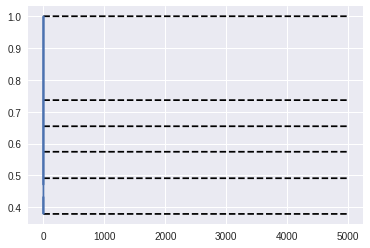

In [121]:
import numpy as np
import matplotlib.pyplot as plt

x = temp.iloc[:,2].sample(5000)
breaks = jenks(x, 5)

for line in breaks:
    plt.plot([line for _ in range(len(x))], 'k--')

plt.plot(x,x)
plt.grid(True)
plt.show()

In [122]:
from sklearn.cluster import KMeans
from jenks import jenks #https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
import ckmeans #https://journal.r-project.org/archive/2011-2/RJournal_2011-2_Wang+Song.pdf

def vars_stats(df, method_col, feature):
    k = len(df[feature].value_counts())
    N = len(df.values)
    n = df.groupby(method_col).size()
    SSqX = sum([value**2 for value in df[feature]])
    SqX = sum(df[feature])**2
    SStotal = SSqX - (SqX/N)
    SSbetween = sum(df.groupby(by=method_col).sum()[feature]**2 /n) - (SqX/N)
    SSwithin = SStotal - SSbetween
    
    return SSwithin, SSbetween
            
def stat_n_bins(n_bins, features, df,v=False, p==False ):
    stats = []
    for i in n_bins:
        n_bin = i
        array = df[features[0]]

        jclasses = jenks(array, n_bin)
        
        kmeans = KMeans(n_clusters=n_bin, n_jobs=-1, precompute_distances=True)
        reshaped = array.values.reshape([-1,1])
        kmeans.fit(reshaped)
        y_kmeans = kmeans.predict(reshaped)
        k_classes = kmeans.labels_
        ck_classes = ckmeans.ckmeans(array,k=n_bin)[0]
        
        df["jclasses"] =  np.array([classify(i, jclasses) for i in array])
        df["k_classes"] =  k_classes
        df["ck_classes"] =  ck_classes
        
        jwvar, jbvar = vars_stats(df, "jclasses", features[1]) #stats are based on Margin
        kwvar, kbvar = vars_stats(df, "k_classes", features[1])
        ckwvar, ckbvar = vars_stats(df, "ck_classes", features[1])
        
        
        stats.append([n_bin,kwvar,kbvar,"kmeans"])
        stats.append([n_bin,jwvar,jbvar, "jenk"])
        stats.append([n_bin,ckwvar,ckbvar,"ckmeans"])
        
        #print(df["jclasses"].value_counts())
        #print(df["k_classes"].value_counts())
        #print(df["ck_classes"].value_counts())
        if p==True:    
            sns.lmplot('margin%', 'extended_cost',
               data=df.sample(10000), 
               fit_reg=False, 
               hue="ck_classes",  
               scatter_kws={"marker": "D",  "s": 50})
            plt.title('extended_cost vs margin')
            plt.ylabel('extended_cost')
            plt.xlabel('margin%')
        
        if v == True:
            print("\n Stats when number of bins is" , n_bin)

            print("\nUsing Jenks")
            print("Mean difference in margin across bins",jbvar )
            print("Total variance within bins                  ", jwvar)

            print("\nUsing K-Means")
            print("Mean difference in margin across bins", kbvar  )
            print("Total variance within bins                   ", kwvar )
            
            print("\nUsing 1D Optimal CKMeans")
            print("Mean difference in margin across bins", ckbvar  )
            print("Total variance within bins                   ", ckwbvar )
        else:
            print("."*n_bin)
     
    dstats = pd.DataFrame(stats)
    dstats.columns = ["n_bin","var_within", "var_between", "method"]
    dstats["ssb/sst"] = dstats["var_between"]/(dstats["var_between"]+dstats["var_within"])
    dstats.sort_values(by="ssb/sst",ascending=False, inplace=True)
    
    return dstats
  

In [196]:
eng_data_stats = stat_n_bins(range(3,15),["extended_cost", "margin%"], good_data)
lgn_data_stats = stat_n_bins(range(3,15),["extended_cost", "margin%"], temp)
orig_stats = stat_n_bins(range(3,15),["extended_cost", "margin%"], p3)

[ 2218.78261337  2674.81954987  4546.60554418]
2    9960
3    9314
1    8827
Name: jclasses, dtype: int64
0    9949
1    9334
2    8818
Name: k_classes, dtype: int64
1    9949
2    9334
0    8818
Name: ck_classes, dtype: int64
...
[ 1560.54436966  1412.50526889  1110.42112807  1647.31256213]
2    7936
1    7910
3    7538
4    4717
Name: jclasses, dtype: int64
1    8288
2    7949
3    7793
0    4071
Name: k_classes, dtype: int64
1    8006
0    7910
2    7491
3    4694
Name: ck_classes, dtype: int64
....
[ 672.79790214  562.75740481  686.02123079  859.41984755  931.7481322 ]
4    6940
3    6556
1    6078
2    5622
5    2905
Name: jclasses, dtype: int64
0    6902
4    6554
2    6095
1    5604
3    2946
Name: k_classes, dtype: int64
3    6908
2    6554
0    6096
1    5603
4    2940
Name: ck_classes, dtype: int64
.....
[ 586.02363799  457.68139733  347.82389036  261.77535496  372.2875899
  511.28107752]
1    5825
3    5400
2    5186
5    5002
4    4882
6    1806
Name: jclasses, dtype: int64

[ 0.61212749  0.37003936  0.37131675  0.54413871  0.55449815  0.39243041
  0.57502176  0.77195881  0.55753052  0.4867375 ]
5     3887
8     3599
7     3346
2     3337
4     3279
6     2851
3     2657
1     2413
9     2125
10     609
Name: jclasses, dtype: int64
1    3699
6    3669
5    3452
3    3277
0    3223
4    3017
7    2674
9    2373
8    2112
2     607
Name: k_classes, dtype: int64
4    3944
7    3812
6    3520
3    3359
1    3277
5    2869
2    2684
0    2373
8    1772
9     493
Name: ck_classes, dtype: int64
..........
[ 0.61212749  0.36810029  0.36583089  0.46239935  0.44366813  0.41495535
  0.26883549  0.33190019  0.26099447  0.33451761  0.39481083]
5     3576
2     3337
4     3266
8     3240
7     2977
6     2812
3     2657
1     2413
9     2026
10    1364
11     435
Name: jclasses, dtype: int64
4     3546
8     3299
9     3205
7     3053
10    3003
2     2826
1     2704
3     2462
0     2206
6     1367
5      432
Name: k_classes, dtype: int64
4     3636
1     3273
3     32

[ 15126854.62781751  12031507.90252599  11056410.13774003
  10215535.82729843   5035384.86722516   6701976.67596246
   8474332.02898759   8682177.33990549   4320357.1211828    6528472.16801875
  10675835.479875    12934863.52509583  10685035.47789167   7033200.1352    ]
1     15816
2      5168
3      3141
4      1861
5       747
6       651
7       289
8       183
9        93
10       80
11       36
12       23
13       13
14        2
Name: jclasses, dtype: int64
0     15816
12     5166
6      3117
2      1777
9       858
4       693
7       249
11      180
8        92
1        79
13       38
5        24
3        12
10        2
Name: k_classes, dtype: int64
0     15817
1      5167
2      3141
3      1862
4       747
5       650
6       290
7       182
8        93
9        80
10       36
11       24
12       12
13        2
Name: ck_classes, dtype: int64
..............


In [191]:
orig_stats = stat_n_bins(range(3,15),["extended_cost", "margin%"], p3)

[  6.80782470e+08   7.58404208e+08   1.41912801e+09]
1    25294
2     2572
3      237
Name: jclasses, dtype: int64
0    25378
2     2511
1      214
Name: k_classes, dtype: int64
0    25369
1     2520
2      214
Name: ck_classes, dtype: int64
...
[  4.16838082e+08   4.63314958e+08   3.65451041e+08   3.71745316e+08]
1    24084
2     3585
3      388
4       46
Name: jclasses, dtype: int64
0    24091
2     3583
1      385
3       44
Name: k_classes, dtype: int64
0    24091
1     3583
2      385
3       44
Name: ck_classes, dtype: int64
....
[  1.25574086e+08   1.71233807e+08   2.35380399e+08   2.12974638e+08
   3.17233920e+08]
1    21053
2     5538
3     1214
4      254
5       44
Name: jclasses, dtype: int64
0    21053
4     5549
1     1221
2      242
3       38
Name: k_classes, dtype: int64
0    21053
1     5549
2     1221
3      242
4       38
Name: ck_classes, dtype: int64
.....
[  1.19982851e+08   1.14809098e+08   1.00212260e+08   7.84583257e+07
   9.05060442e+07   2.93908975e+08]
1  

In [209]:
orig_stats

,n_bin,var_within,var_between,method,ssb/sst
23,10,681.418593,642.101211,ckmeans,0.485147
22,10,681.800168,641.719636,jenk,0.484858
26,11,681.812588,641.707216,ckmeans,0.484849
24,11,681.856137,641.663667,kmeans,0.484816
21,10,681.878389,641.641415,kmeans,0.484799
35,14,681.985286,641.534518,ckmeans,0.484718
32,13,681.987734,641.532070,ckmeans,0.484717
30,13,682.050214,641.469590,kmeans,0.484669
34,14,682.129650,641.390154,jenk,0.484609
31,13,682.130226,641.389578,jenk,0.484609


/home/raz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,20.8,'margin%')

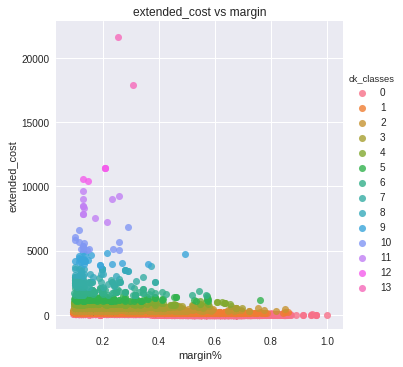

In [195]:
#Scatter plot of Wattage and Duration

plt.figure(figsize=(14,10)) #set size

#Scatter plot of Wattage and Duration

#plt.figure(figsize=(14,10)) #set size
def makedf(indf):
    data = pd.DataFrame()
    data = np.exp(indf.iloc[:,:5])
    data["jclasses"] = indf["jclasses"]
    data["k_classes"] =  indf["k_classes"]
    data["ck_classes"] =  indf["ck_classes"]
    return data.sample(500)

data = makedf(p3)




/home/raz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/raz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


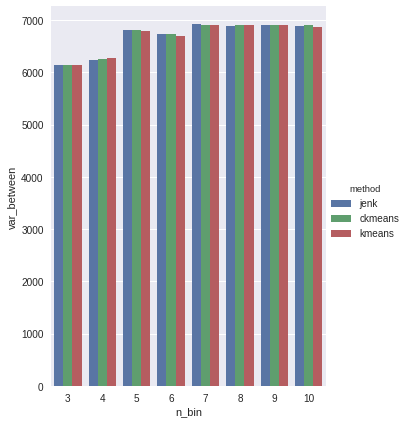

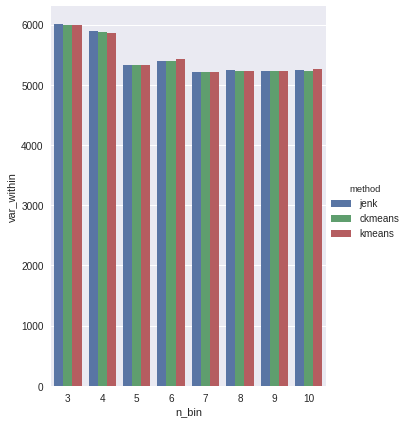

In [125]:
g = sns.factorplot(x="n_bin", y="var_between",
                    hue="method",
    
                   
                   
                   
                   
                   
                   
                   
                   
                   data=eng_data_stats, kind="bar",
                    size=6, aspect=.8);


g = sns.factorplot(x="n_bin", y="var_within",
                    hue="method",
                    data=eng_data_stats, kind="bar",
                    size=6, aspect=.8);



In [126]:
good_data["ck_classes"].value_counts().var()

1107346.9888888886

In [189]:
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_pca_samples(df, n_bin):
    pca = PCA(n_components=n_bin)
    pca.fit(df)
    pca_samples = pd.DataFrame(pca.transform(df))
    return pca_samples


range_n_clusters = list(range(2,11))
a=get_pca_samples(temp[["extended_cost","margin%"]], 2).sample(5000)
#a = p3["extended_cost"].sample(5000).reshape([-1,1])

# Loop through clusters
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters).fit(a)
    preds = clusterer.predict(a)
    print(clusterer.labels_)
    score = silhouette_score(a, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

    clusterer = GMM(n_components=n_clusters).fit(a)
    preds = clusterer.predict(a)
    score = silhouette_score(a, preds, metric='mahalanobis')
    print( "For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

[1 1 0 ..., 0 1 0]
For n_clusters = 2. The average silhouette_score is : 0.43580183036287906


/home/raz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/raz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/raz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


For n_clusters = 2. The average silhouette_score is : 0.42350645121255887
[0 2 1 ..., 1 0 1]
For n_clusters = 3. The average silhouette_score is : 0.3274387046766117
For n_clusters = 3. The average silhouette_score is : 0.35998404851641147
[3 0 1 ..., 1 3 1]
For n_clusters = 4. The average silhouette_score is : 0.2666763025484647
For n_clusters = 4. The average silhouette_score is : 0.2870766464921272
[1 2 3 ..., 3 1 3]
For n_clusters = 5. The average silhouette_score is : 0.2643325038016855
For n_clusters = 5. The average silhouette_score is : 0.25300496331941275
[1 2 0 ..., 0 1 0]
For n_clusters = 6. The average silhouette_score is : 0.23725891564479543
For n_clusters = 6. The average silhouette_score is : 0.2230259778009523
[1 5 2 ..., 2 1 2]
For n_clusters = 7. The average silhouette_score is : 0.1415344141598919
For n_clusters = 7. The average silhouette_score is : 0.16871628032941988
[6 4 1 ..., 3 6 1]
For n_clusters = 8. The average silhouette_score is : 0.1705478434970655
For n